In [55]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

from datetime import datetime

In [56]:
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')

In [57]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [59]:
#Load data
orders = pd.read_excel('Orders.xlsx', sheet_name='Orders')

In [60]:
orders.head()

,OrderID,CustomerID,SalespersonPersonID,ContactPersonID,OrderDate,ExpectedDeliveryDate,CustomerPurchaseOrderNumber,# Products,Picked Quantity,Total Sale,Total Plus Tax
0,1,832,2,3032,2015-01-01,2015-01-02,12126,1,10,3450.0,3967.500
1,2,803,8,3003,2015-01-01,2015-01-02,15342,2,18,607.5,698.625
2,3,105,7,1209,2015-01-01,2015-01-02,12211,1,3,135.0,155.250
3,4,57,16,1113,2015-01-01,2015-01-02,17129,3,103,667.8,767.970
4,5,905,3,3105,2015-01-01,2015-01-02,10369,3,27,1056.0,1214.400


In [61]:
#define the problem: how many sales are we getting per month?

pd.to_datetime(orders['OrderDate'])
orders.set_index('OrderDate', inplace=True)

In [62]:
#aggregate into months

monthly_sales = orders[['Total Sale']].resample('M').sum()

In [63]:
monthly_sales

,Total Sale
OrderDate,
2015-01-31,5737264.275
2015-02-28,4231923.300
2015-03-31,5949117.150
2015-04-30,6233565.075
2015-05-31,6844245.525
2015-06-30,6225147.900
2015-07-31,6754112.775
2015-08-31,5401830.900
2015-09-30,5874004.875


In [22]:
monthly_sales.head()

,Total Sale
OrderDate,
2015-01-31,5737264.275
2015-02-28,4231923.300
2015-03-31,5949117.150
2015-04-30,6233565.075
2015-05-31,6844245.525


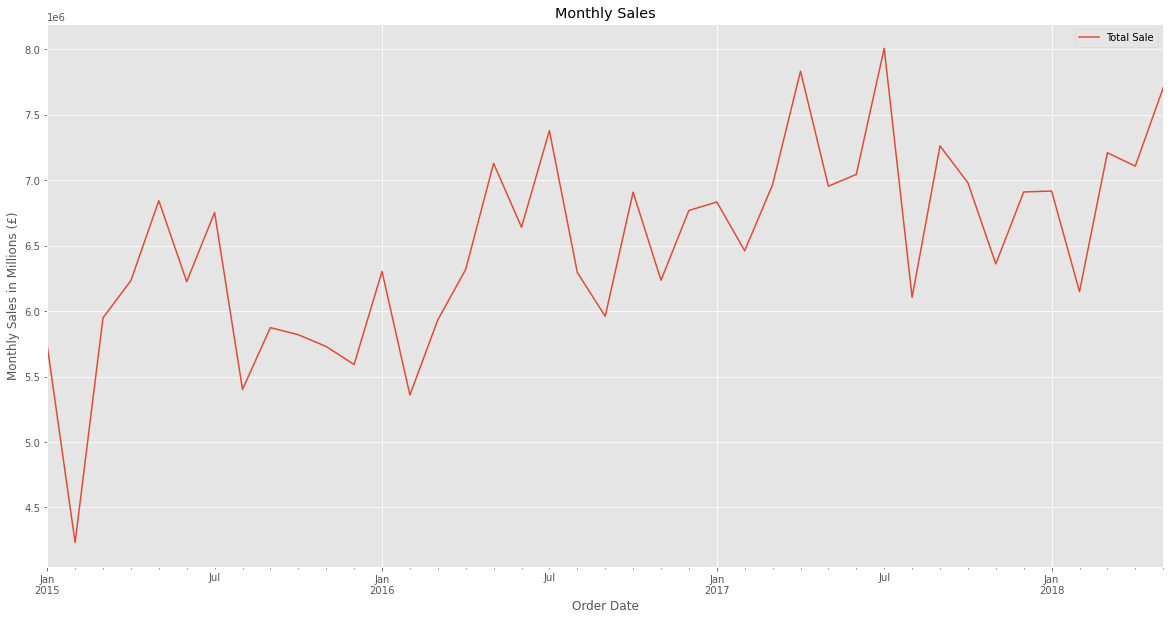

In [23]:
#Time Series
monthly_sales.plot()
plt.ylabel("Monthly Sales in Millions (£)")
plt.xlabel("Order Date")
plt.title("Monthly Sales")
plt.show()

In [24]:
monthly_sales = monthly_sales.rename(columns={'Total Sale':'totalsales'})

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

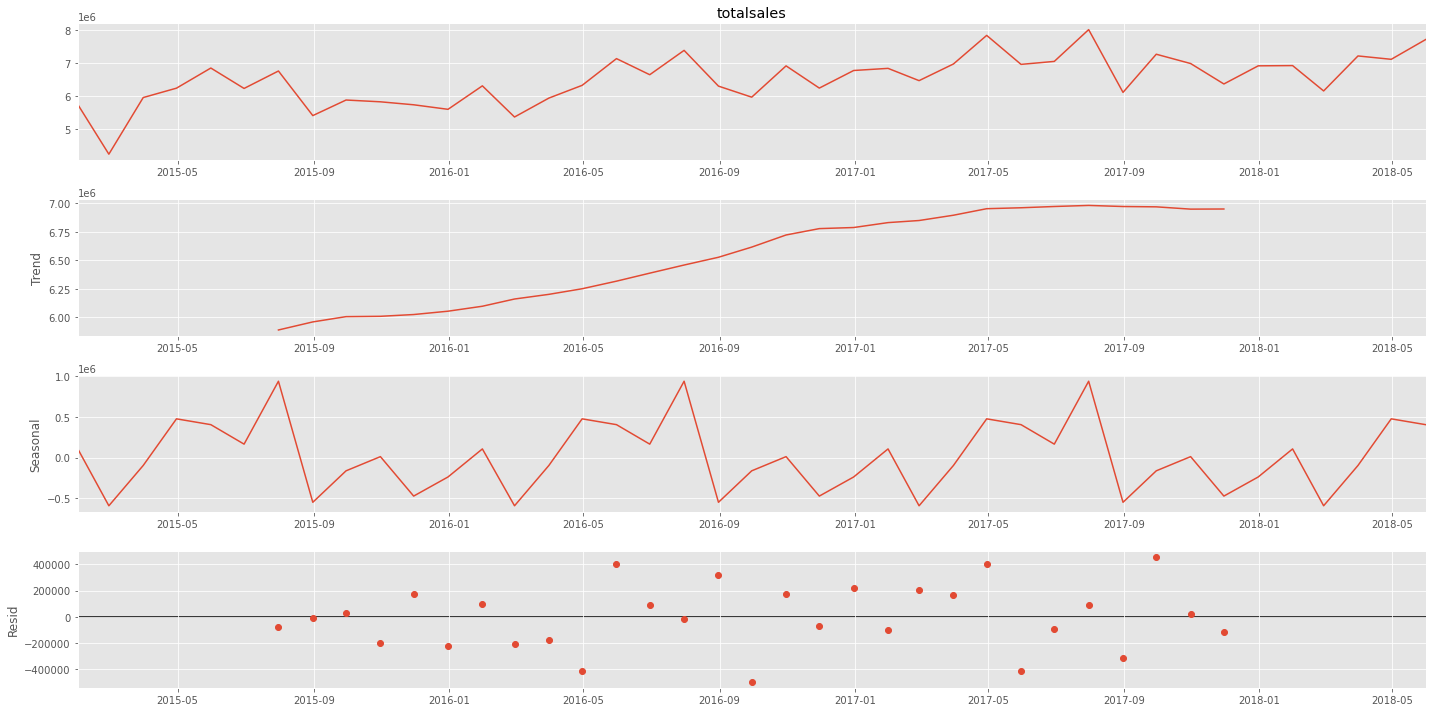

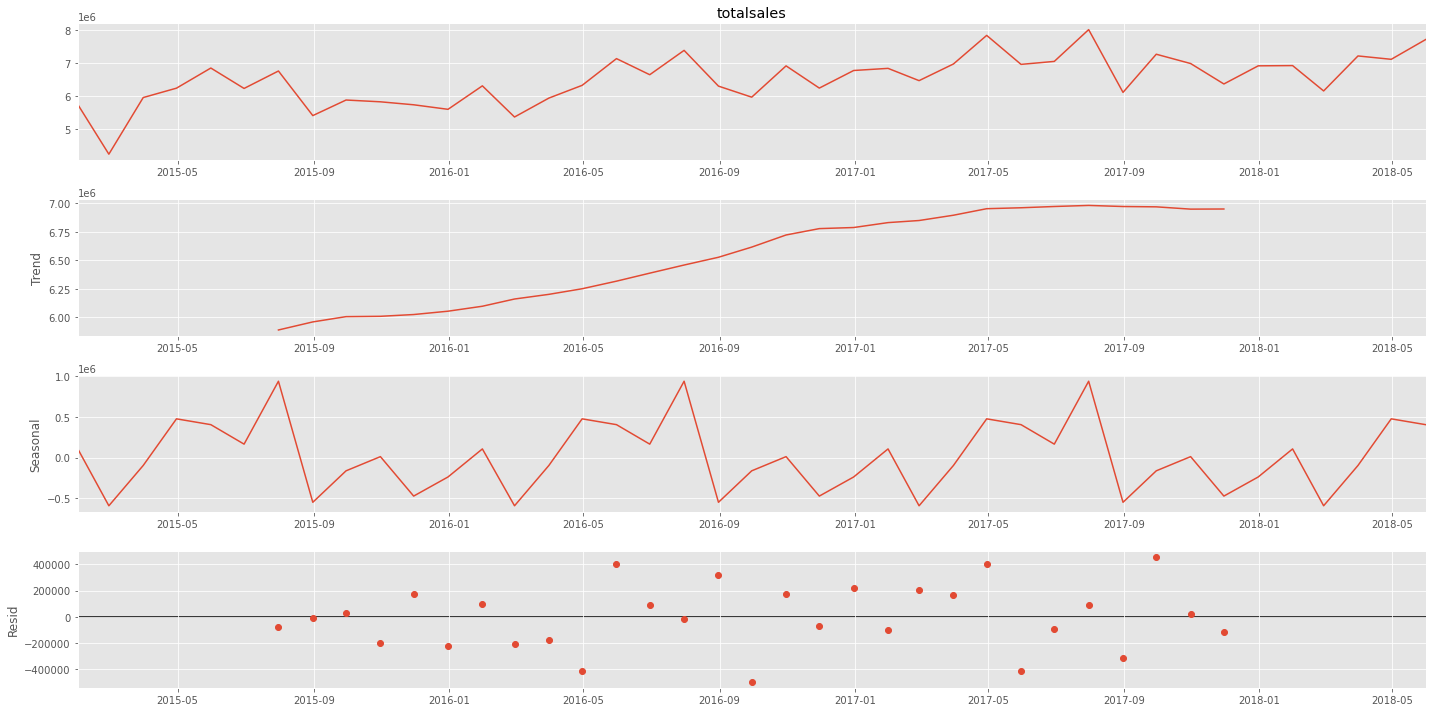

In [26]:
decomposition = seasonal_decompose(monthly_sales.totalsales, period=12)
decomposition.plot()

No handles with labels found to put in legend.


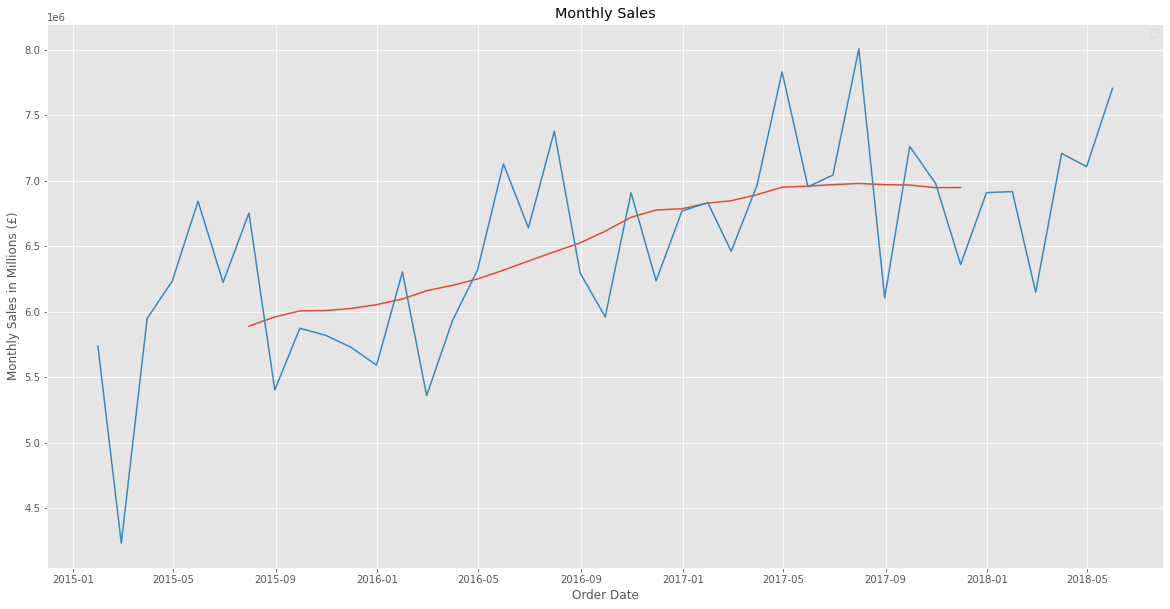

In [27]:
#Is it stationary?

plt.plot(decomposition.trend)
plt.plot(monthly_sales.index, monthly_sales['totalsales'])
plt.legend()
plt.ylabel("Monthly Sales in Millions (£)")
plt.xlabel("Order Date")
plt.title("Monthly Sales")
plt.show()

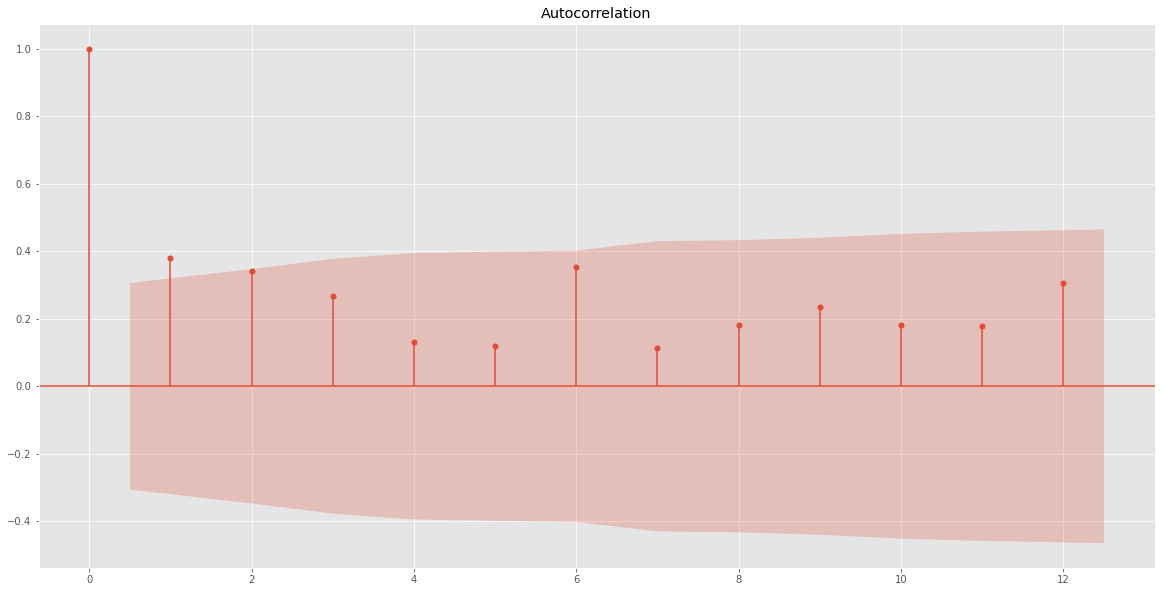

In [28]:
plot_acf(monthly_sales, lags=12)
plt.show()

In [29]:
monthly_sales_diff = monthly_sales.totalsales.diff(1).dropna()

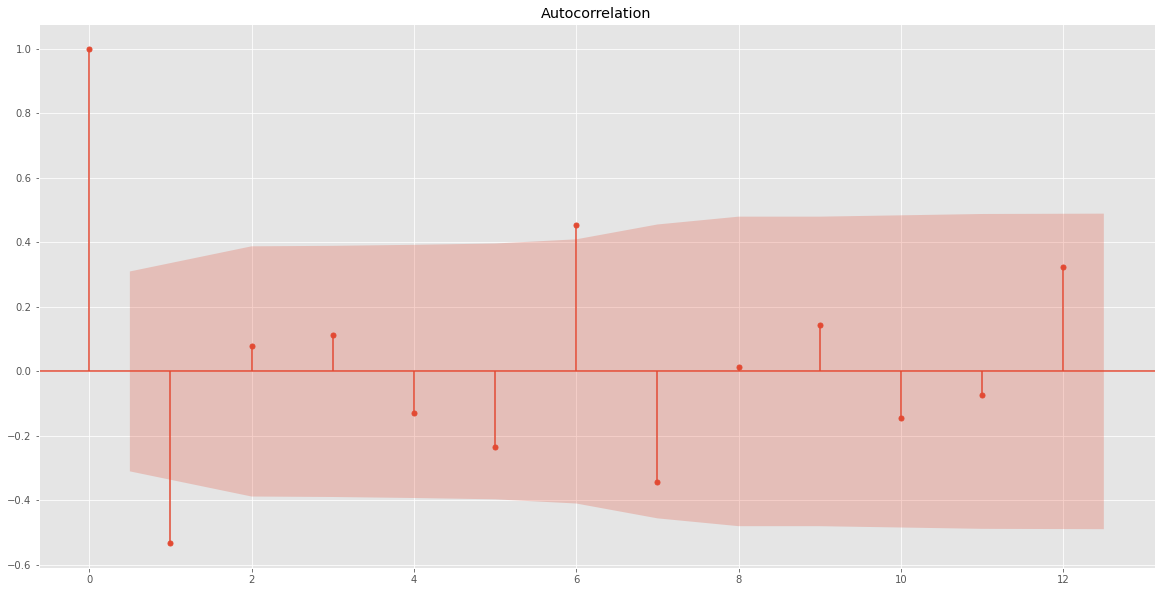

In [30]:
plot_acf(monthly_sales_diff, lags=12)
plt.show()

In [31]:
train = pd.DataFrame(monthly_sales['2015':'2017'])

In [32]:
test = pd.DataFrame(monthly_sales['2018'])

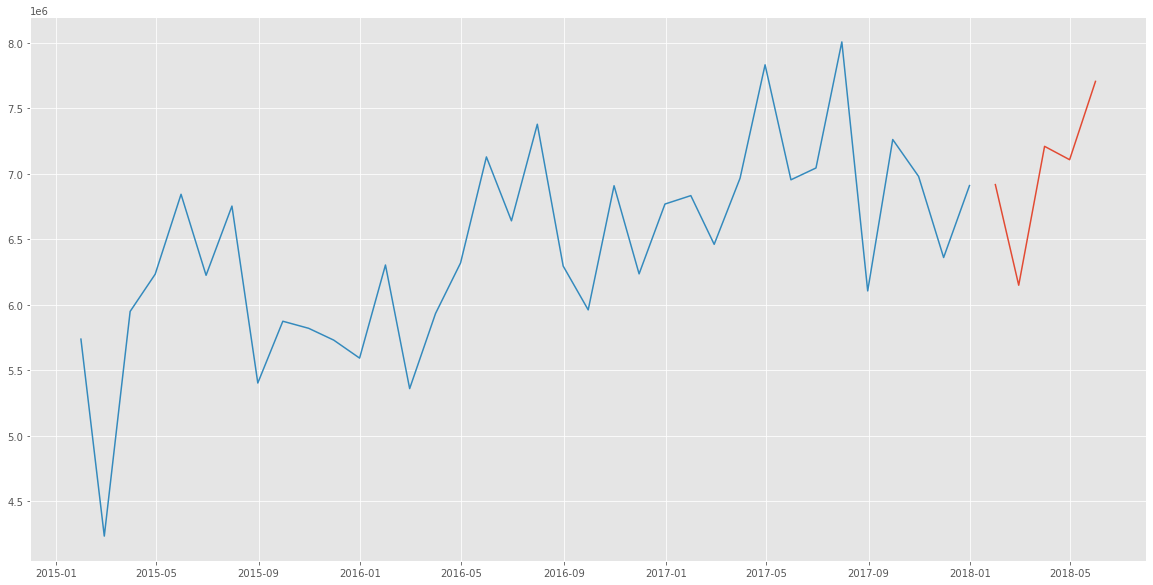

In [33]:
plt.plot(test)
plt.plot(train)

In [34]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Grid Search / Hyperparameter Optimization for Model selection - (be able to pick up the smallest AIC Value).
# Generate all different combinations of seasonal p, q and q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# SARIMAX returns the AIC Value
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [35]:
# Ignore warning messages
warnings.filterwarnings("ignore")

# Generate an AIC Value
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue
results

In [36]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
AIC.append(results.aic)
SARIMAX_model.append([param, param_seasonal])

In [37]:
# AIC Value?
mod

In [38]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 6.0 for model SARIMAX(0, 0, 0)x(2, 1, 0, 12)


In [39]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(train,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [40]:
# Use plot diagnostics to check if it meets our expecatations
results.plot_diagnostics(figsize=(20, 14))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1440x1008 with 0 Axes>

In [49]:
# Sample prediction with 1-step ahead forecasting of the last year 1967 
# Model is asked to predict data using existing data 
pred0 = results.get_prediction(start='01-2018', dynamic=False)
pred0_ci = pred0.conf_int()

In [50]:
print(pred0.predicted_mean['01-2018':])

2018-01-31    6834097.875
Freq: M, dtype: float64


In [51]:
# Sample prediction with dynamic forecasting of the last year 1967
# Model is asked to predict data using existing data 

pred1 = results.get_prediction(start='01-2018', dynamic=True)
pred1_ci = pred1.conf_int()

In [52]:
# True forecasting 
# Model is asked to predict data its not seen before 

pred2 = results.get_forecast('12-2019')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['01-2018':'12-2019'])

2018-01-31    6834097.875
2018-02-28    6461728.875
2018-03-31    6966963.525
2018-04-30    7833892.275
2018-05-31    6954942.675
2018-06-30    7045299.975
2018-07-31    8008818.000
2018-08-31    6105789.900
2018-09-30    7262845.050
2018-10-31    6980761.350
2018-11-30    6360918.450
2018-12-31    6910773.225
2019-01-31    6834097.875
2019-02-28    6461728.875
2019-03-31    6966963.525
2019-04-30    7833892.275
2019-05-31    6954942.675
2019-06-30    7045299.975
2019-07-31    8008818.000
2019-08-31    6105789.900
2019-09-30    7262845.050
2019-10-31    6980761.350
2019-11-30    6360918.450
2019-12-31    6910773.225
Freq: M, Name: predicted_mean, dtype: float64


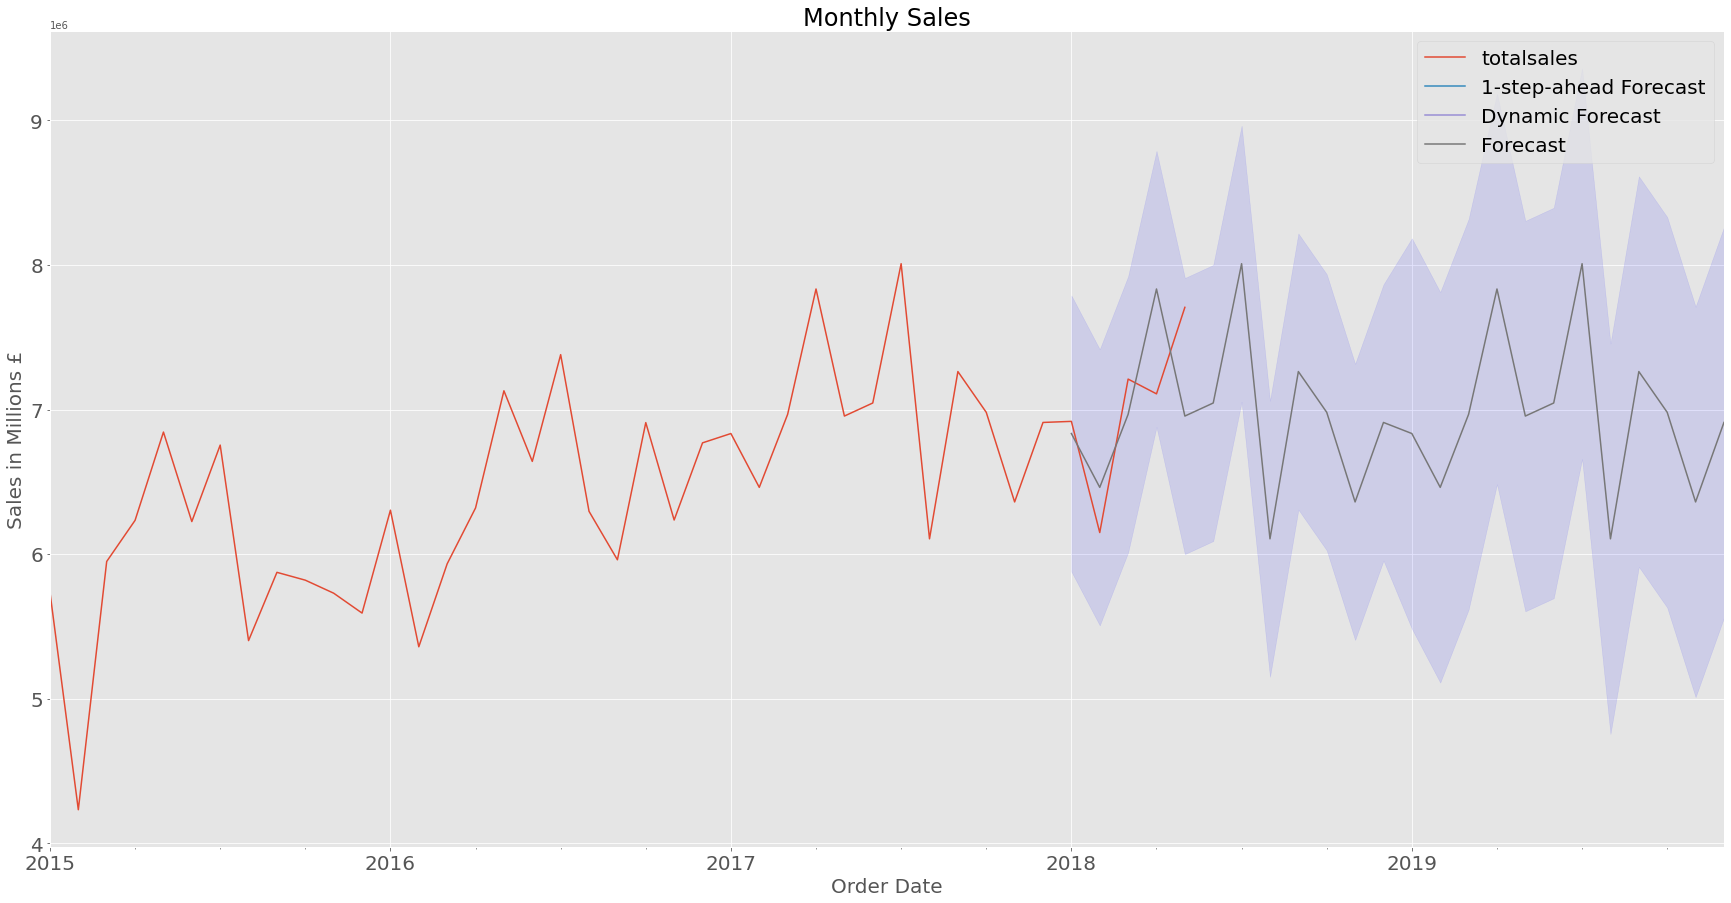

In [53]:
# Plot all data

ax = monthly_sales.plot(figsize=(30, 15), fontsize=(20))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
pred2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='blue', alpha=.1)
plt.title('Monthly Sales', fontsize='24')
plt.ylabel('Sales in Millions £', fontsize='20')
plt.xlabel('Order Date', fontsize='20')
plt.legend(fontsize='20')
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [47]:
pred2_rmse = pred2.predicted_mean['01-2018':'05-2018'] 

In [172]:
rms_sarima = sqrt(mean_squared_error(test, pred2_rmse))
print("The RMSE is:")
print(round(rms_sarima))

The RMSE is:
501157


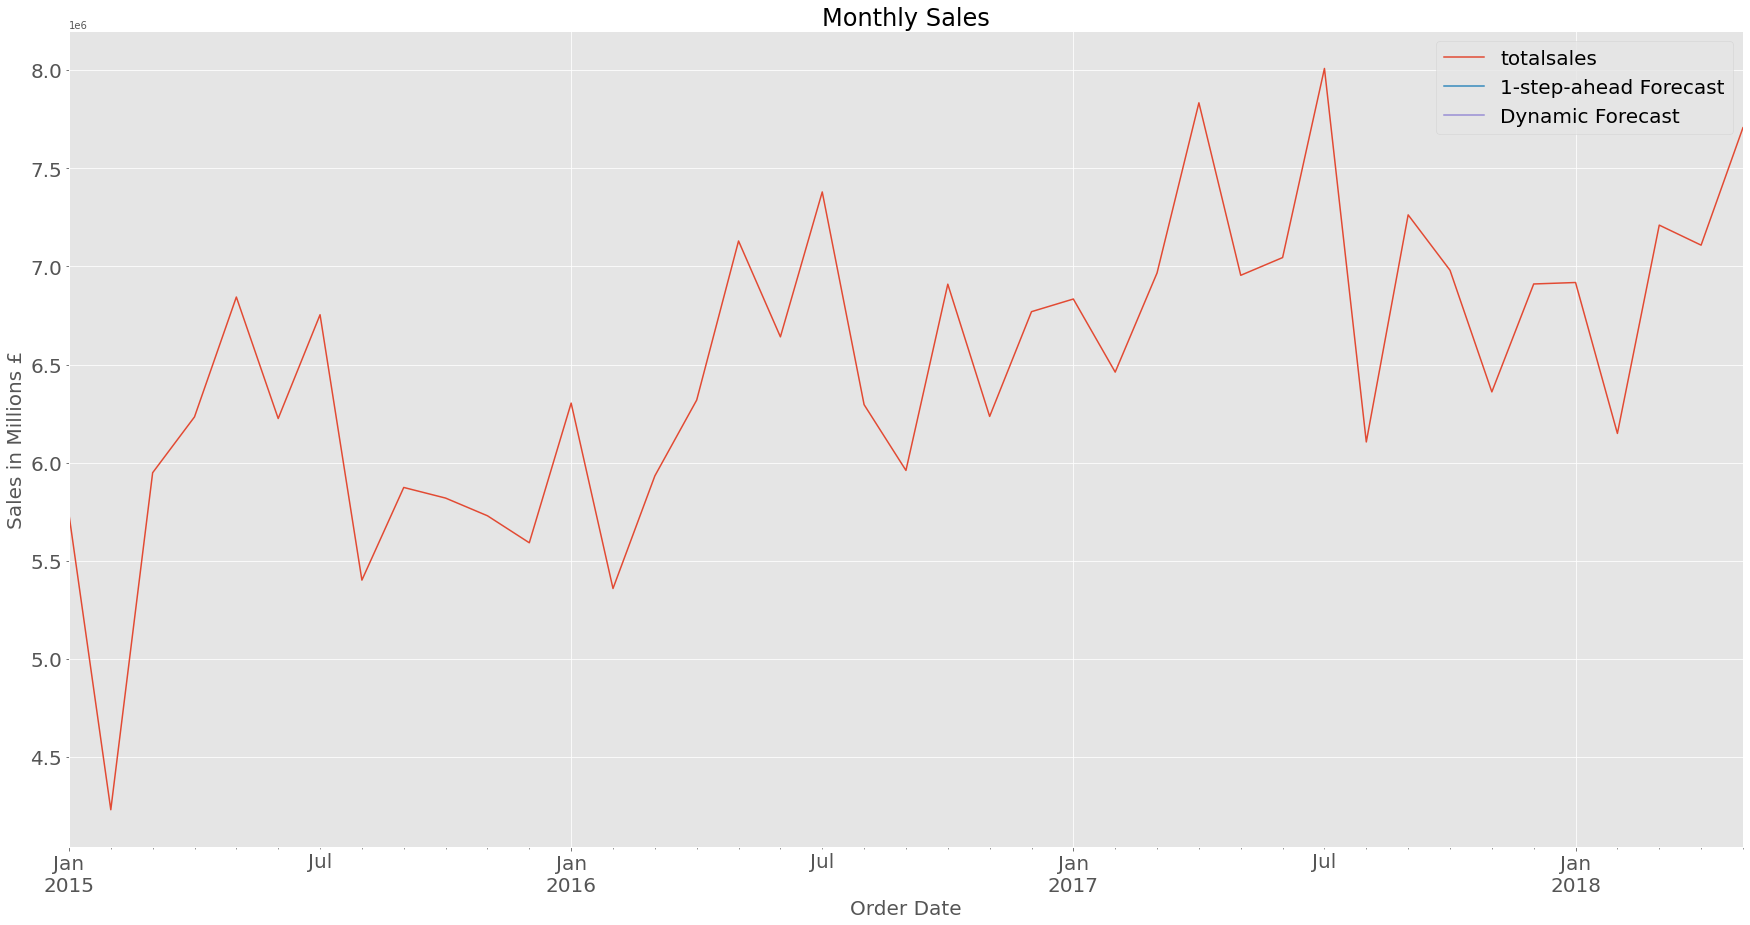

In [54]:
# Plot all data

ax = monthly_sales.plot(figsize=(30, 15), fontsize=(20))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast')

plt.title('Monthly Sales', fontsize='24')
plt.ylabel('Sales in Millions £', fontsize='20')
plt.xlabel('Order Date', fontsize='20')
plt.legend(fontsize='20')
plt.show()